# preprocessing

In [67]:
!git clone https://github.com/ItamarBerger/TabularDS

fatal: destination path 'TabularDS' already exists and is not an empty directory.


In [68]:
# load dataset
import pandas as pd
data = pd.read_csv('/content/TabularDS/final_project/code/data/online_retail.csv')
# data = retails.copy()

In [69]:
# retails.head()
# print(len(retails))
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#Apriori for rule mining

In [70]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

transactions = data.groupby('InvoiceNo')['Description'].apply(list).tolist()

In [71]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

transactions = transactions[0:300]
# Convert the transaction data into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori to find frequent itemsets (min_support can be adjusted based on your needs)
frequent_itemsets = apriori(df, min_support=0.015, use_colnames=True)

# Generate association rules (min_threshold can be adjusted for confidence)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the results
print(rules)


                                           antecedents  \
0                    (PACK OF 72 RETROSPOT CAKE CASES)   
1                        (60 TEATIME FAIRY CAKE CASES)   
2                          (ALARM CLOCK BAKELIKE PINK)   
3                         (ALARM CLOCK BAKELIKE GREEN)   
4                          (ALARM CLOCK BAKELIKE RED )   
..                                                 ...   
245  (JUMBO STORAGE BAG SUKI, JUMBO SHOPPER VINTAGE...   
246  (JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...   
247                           (JUMBO STORAGE BAG SUKI)   
248                          (JUMBO BAG RED RETROSPOT)   
249                (JUMBO SHOPPER VINTAGE RED PAISLEY)   

                                           consequents  antecedent support  \
0                        (60 TEATIME FAIRY CAKE CASES)            0.054569   
1                    (PACK OF 72 RETROSPOT CAKE CASES)            0.034198   
2                         (ALARM CLOCK BAKELIKE GREEN)            0.0

In [72]:
# top rules by lift
top_lift_rules = rules.sort_values('lift', ascending=False).head(100)
print(top_lift_rules)


                                           antecedents  \
219              (WOODEN HEART CHRISTMAS SCANDINAVIAN)   
218               (WOODEN STAR CHRISTMAS SCANDINAVIAN)   
220  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
225                   (PINK REGENCY TEACUP AND SAUCER)   
222  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
..                                                 ...   
143                           (LUNCH BAG APPLE DESIGN)   
147                              (LUNCH BAG CARS BLUE)   
146                          (LUNCH BAG PINK POLKADOT)   
237                (JUMBO SHOPPER VINTAGE RED PAISLEY)   
232  (JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...   

                                           consequents  antecedent support  \
219               (WOODEN STAR CHRISTMAS SCANDINAVIAN)            0.022090   
218              (WOODEN HEART CHRISTMAS SCANDINAVIAN)            0.021067   
220                   (PINK REGENCY TEACUP AND SAUCER)            0.0

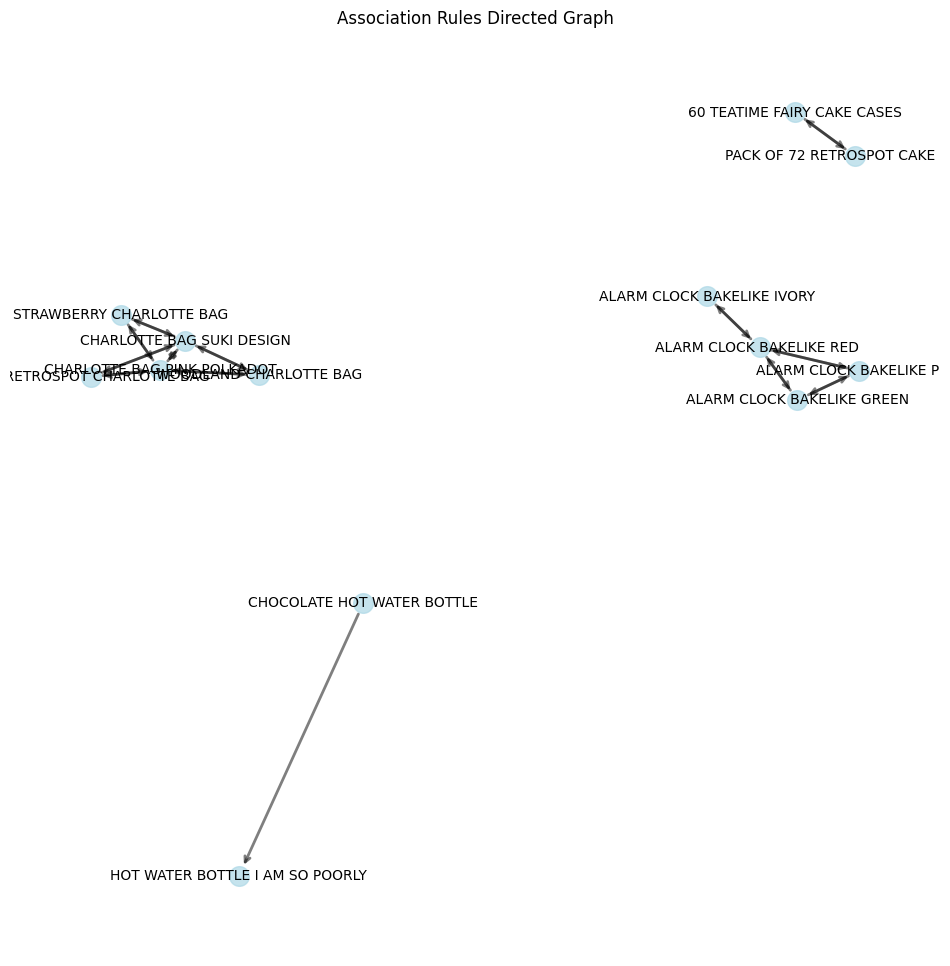

In [73]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Create a directed graph
G = nx.DiGraph()
narrow_rules = rules[0:25]
# Add nodes and directed edges
for _, rule in narrow_rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))

    # Add a directed edge from antecedent to consequent
    G.add_edge(antecedent, consequent, weight=rule['lift'], support=rule['support'], confidence=rule['confidence'])

# Draw the directed graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3, iterations=20)  # Layout for the graph

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.5, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add edge labels (optional, if you want to display lift, confidence, or support)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Association Rules Directed Graph")
plt.axis('off')
plt.show()



In [74]:
import plotly.graph_objects as go
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Example association rules (you need to load your own rules here)
# Example: rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and directed edges
for _, rule in narrow_rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))

    # Add a directed edge from antecedent to consequent
    G.add_edge(antecedent, consequent, weight=rule['lift'], support=rule['support'], confidence=rule['confidence'])

# Get positions of nodes using a layout
pos = nx.spring_layout(G, k=0.3, iterations=20)

# Get edge and node information for Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_y.append(y0)
    edge_x.append(x1)
    edge_y.append(y1)

# Node positions
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Create hover text for nodes (empty text for default)
hover_text = [node for node in G.nodes()]

# Create the plotly figure
fig = go.Figure()

# Add directed edges with arrows (using annotations for arrows)
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    # Add edge line
    fig.add_trace(go.Scatter(x=[x0, x1], y=[y0, y1],
                             line=dict(width=1, color='gray'),
                             mode='lines',
                             showlegend=False))

    # Add arrow (using annotations)
    fig.add_annotation(
        x=x1, y=y1,
        ax=x0, ay=y0,
        axref="x", ayref="y", xref="x", yref="y",
        showarrow=True, arrowhead=2, arrowsize=1,
        arrowcolor='gray', opacity=0.7
    )

# Add nodes to the plot
fig.add_trace(go.Scatter(x=node_x, y=node_y,
                         mode='markers',
                         hoverinfo='text',  # This ensures text shows on hover only
                         hovertext=hover_text,  # Set hovertext to show item names on hover
                         marker=dict(color='skyblue', size=10, line=dict(width=1, color='black'))))

# Add edge labels (optional: you can use lift or other metrics)
edge_labels = nx.get_edge_attributes(G, 'weight')
for edge, label in edge_labels.items():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[(x0+x1)/2], y=[(y0+y1)/2],
                             text=[f'Lift: {label:.2f}'],
                             mode='text',
                             showlegend=False))

# Update layout settings for better visualization
fig.update_layout(title="Association Rules Directed Graph (Interactive)",
                  showlegend=False,
                  hovermode='closest',
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False))

# Show the plot
fig.show()


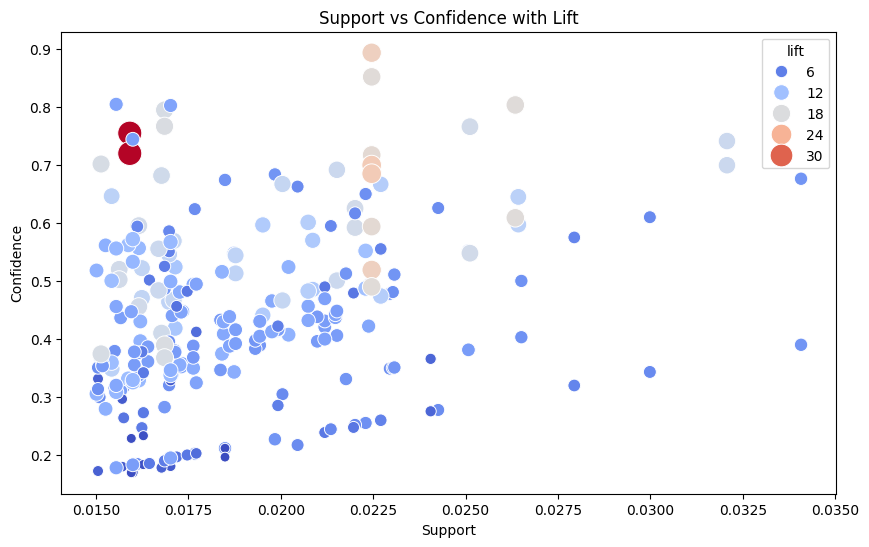

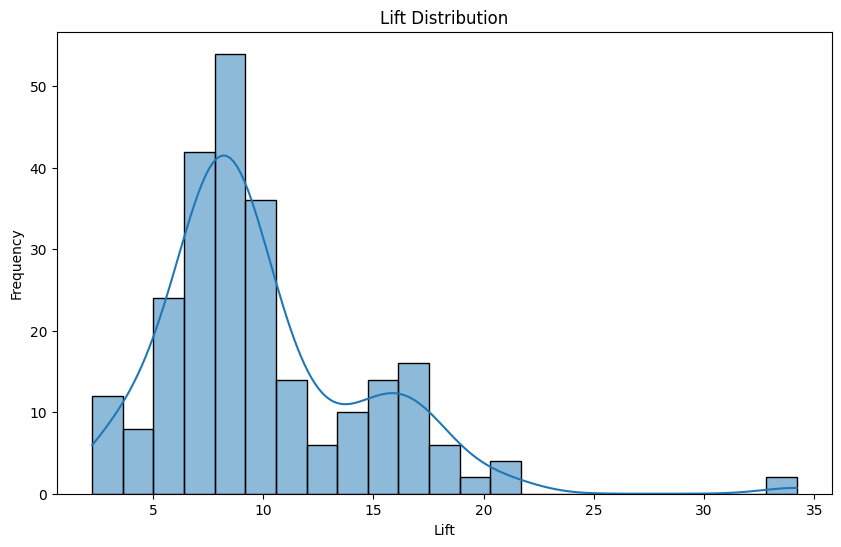

In [75]:
import seaborn as sns

# Plot support vs confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', data=rules, hue='lift', palette='coolwarm', size='lift', sizes=(50, 300))
plt.title("Support vs Confidence with Lift")
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

# Plot lift distribution
plt.figure(figsize=(10, 6))
sns.histplot(rules['lift'], kde=True)
plt.title("Lift Distribution")
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.show()


# Using item-based CF for rules mining

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

transactions = transactions


def calculate_jaccard_similarity(transaction_matrix):
    """Calculate Jaccard similarity between all item pairs"""
    binary_matrix = (transaction_matrix > 0).astype(int)
    jaccard_dist = pdist(binary_matrix.T, metric='jaccard')
    jaccard_sim = 1 - squareform(jaccard_dist)
    return pd.DataFrame(jaccard_sim, index=transaction_matrix.columns, columns=transaction_matrix.columns)

def calculate_item_means(transaction_matrix):
    """Calculate mean occurrence (probability) for each item"""
    return transaction_matrix.mean()

def calculate_recommendation_score(transaction_items, candidate_item, item_similarity_df, transaction_matrix):
    """
    Calculate recommendation score using adjusted formula for binary ratings:
    score(u,i) = Σj similarity(i,j)(r(u,j) - r̄j) / Σj |similarity(i,j)| + r̄i
    where:
    - r(u,j) is 1 if item j is in transaction, 0 otherwise
    - r̄j is the mean occurrence of item j across all transactions
    - r̄i is the mean occurrence of candidate item i
    """
    # Get mean occurrences for all items
    item_means = calculate_item_means(transaction_matrix)

    numerator = 0
    denominator = 0

    # Calculate the weighted sum of deviations from mean
    for item in transaction_items:
        similarity = item_similarity_df.loc[candidate_item, item]
        # r(u,j) is 1 since item is in transaction
        rating_deviation = 1 - item_means[item]  # (r(u,j) - r̄j)
        numerator += similarity * rating_deviation
        denominator += abs(similarity)

    # Add the candidate item's mean occurrence
    mean_i = item_means[candidate_item]

    if denominator != 0:
        score = (numerator / denominator) + mean_i
    else:
        score = mean_i

    return score

def generate_transaction_rules(transactions):
    # Create binary transaction matrix
    item_list = sorted(set([item for sublist in transactions for item in sublist]))
    transaction_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=item_list)
    for idx, transaction in enumerate(transactions):
        for item in transaction:
            transaction_matrix.at[idx, item] = 1

    # Calculate item similarity
    item_similarity_df = calculate_jaccard_similarity(transaction_matrix)

    # Generate recommendations
    recommendations = []

    for transaction in transactions:
        scores = {}

        # Calculate scores for all possible items not in transaction
        for candidate_item in item_list:
            if candidate_item not in transaction:
                score = calculate_recommendation_score(
                    transaction,
                    candidate_item,
                    item_similarity_df,
                    transaction_matrix
                )
                scores[candidate_item] = score

        if scores:
            # Get best recommendation
            best_item = max(scores.items(), key=lambda x: x[1])

            recommendation = {
                'transaction': transaction,
                'recommended_item': best_item[0],
                'score': best_item[1]
            }
            recommendations.append(recommendation)

    return pd.DataFrame(recommendations)


# Usage
rules_df = generate_transaction_rules(transactions)



In [ ]:
rules_df.head()

In [ ]:
# Function to calculate support, confidence, lift, and more
def calculate_metrics(rule, all_transactions):
    antecedent = set(rule['transaction'])
    consequent = set([rule['recommended_item']])

    # Calculate support
    support_antecedent = sum(1 for transaction in all_transactions if antecedent.issubset(set(transaction))) / len(all_transactions)
    support_consequent = sum(1 for transaction in all_transactions if consequent.issubset(set(transaction))) / len(all_transactions)
    support_rule = sum(1 for transaction in all_transactions if antecedent.issubset(set(transaction)) and consequent.issubset(set(transaction))) / len(all_transactions)

    # Calculate confidence
    confidence = support_rule / support_antecedent if support_antecedent != 0 else 0

    # Calculate lift
    lift = confidence / support_consequent if support_consequent != 0 else 0

    # Calculate leverage
    expected_support = support_antecedent * support_consequent
    leverage = support_rule - expected_support

    # Calculate conviction
    conviction = (1 - support_consequent) / (1 - confidence) if confidence < 1 else np.inf

    return {
        'support_antecedent': support_antecedent,
        'support_consequent': support_consequent,
        'support_rule': support_rule,
        'confidence': confidence,
        'lift': lift,
        'leverage': leverage,
        'conviction': conviction
    }

# Calculate metrics for each rule
metrics = []
for _, rule in rules_df.iterrows():
    rule_metrics = calculate_metrics(rule, transactions)
    metrics.append(rule_metrics)

# Add metrics to the DataFrame
metrics_df = pd.DataFrame(metrics)

# Combine the original rules with the calculated metrics
df_rules = pd.concat([rules_df, metrics_df], axis=1)

print(df_rules)

In [ ]:
# Sort the rules by average rating and select the top 100
top_100_rules = df_rules.sort_values(by='conviction', ascending=False).head(100)

# Display the top 100 rules
print(top_100_rules[['lift', 'conviction']])

In [ ]:
print(top_100_rules[['antecedents', 'consequents', 'lift', 'rating', 'confidence', 'support']])


In [ ]:
# perform item-based CF for rule mining
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_item_ratings(invoice_items, item_sim_df):
    """
    Calculate predicted rating for items not in the invoice.
    Rating(Item X) = sum(sim(Item X, item_in_invoice)) / sum(similarities)
    """
    scores = {}
    norm_factor = 0

    for item in invoice_items:
        similar_items = item_sim_df[item].drop(index=invoice_items, errors="ignore")  # Remove existing items
        for sim_item, similarity in similar_items.items():
            scores[sim_item] = scores.get(sim_item, 0) + similarity  # Aggregate similarity scores
            norm_factor += similarity  # Normalize by sum of similarities

    if norm_factor == 0:
        return {}

    # Normalize scores
    for item in scores:
        scores[item] /= norm_factor

    return scores

In [ ]:
from tqdm.notebook import tqdm
threshold = 0.2  # Min rating for an item to be considered

rules = []
for invoice in tqdm(df_onehot.index,desc="Processing Raiting"):
    existing_items = df_onehot.columns[df_onehot.loc[invoice] == 1].tolist()
    predicted_ratings = compute_item_ratings(existing_items, item_sim_df)

    # Select items with rating above threshold
    recommended_items = {item for item, score in predicted_ratings.items() if score > threshold}

    if recommended_items:
        rules.append((set(existing_items), recommended_items))  # Format: {A, B, C} → {D, F}

rules_df = pd.DataFrame(rules, columns=["Antecedent", "Consequent"])


In [ ]:
# compute Confidence and Lift
def compute_rule_metrics(rules_df, df_onehot):
    total_invoices = len(df_onehot)
    metrics = []

    for _, row in rules_df.iterrows():
        antecedent = row["Antecedent"]
        consequent = row["Consequent"]

        support_A = (df_onehot[list(antecedent)].sum(axis=1) == len(antecedent)).mean()
        support_B = (df_onehot[list(consequent)].sum(axis=1) == len(consequent)).mean()
        support_A_B = ((df_onehot[list(antecedent)].sum(axis=1) == len(antecedent)) &
                       (df_onehot[list(consequent)].sum(axis=1) == len(consequent))).mean()

        confidence = support_A_B / support_A if support_A > 0 else 0
        lift = confidence / support_B if support_B > 0 else 0
        interestingness = confidence * lift  # Tradeoff metric

        metrics.append((antecedent, consequent, confidence, lift, interestingness))

    return pd.DataFrame(metrics, columns=["Antecedent", "Consequent", "Confidence", "Lift", "Interestingness"])

rules_eval_df = compute_rule_metrics(rules_df, df_onehot)




In [ ]:
# Select Top 100 Most Interesting Rules
top_100_rules = rules_eval_df.sort_values(by="Interestingness", ascending=False).head(100)
print(top_100_rules)